<a href="https://colab.research.google.com/github/EnterTheBeginning/SmartHomeEnergyForecasting/blob/master/Feature_engineering_for_EnergyPriceForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Working 2:  tsfresh more loads 
Needs features names. 
It must be time,
PCA at end
Goal is finnished Paper and Presentation today. Tommorow i just finalize everything. Grammly and practice for presentation 2h 
optional: Add weekdays,weekends features, Hours features Too? 1/24


In [0]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout, GRU, Bidirectional,Activation,Flatten
import math
from sklearn.metrics import mean_squared_error

from keras.optimizers import SGD
from scipy import stats

import statsmodels.api as sm
import seaborn as sns

from google.colab import drive
drive.mount('/content/gdrive')

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#import the dataset
df = pd.read_excel('/content/gdrive/My Drive/Colab Notebooks/1. DataAnalytics/~Code/Data/Price.xlsx',parse_dates=['time'])


In [0]:
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]


In [0]:
df['time'] = pd.to_datetime(df['time'],unit='ms')
df['time'] = df['time'].astype('datetime64[ns]')
df = df.set_index('time')


In [0]:
hour = df.resample('h').mean()
df =df.fillna(df.mean())
hour = hour.fillna(hour.mean())
hour.isnull().sum()


price    0
dtype: int64

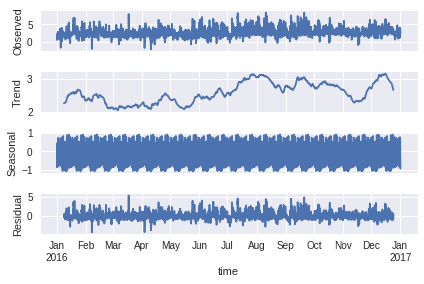

In [0]:
decomposition = sm.tsa.seasonal_decompose(hour['price'], freq=360)

fig = decomposition.plot()
plt.show()


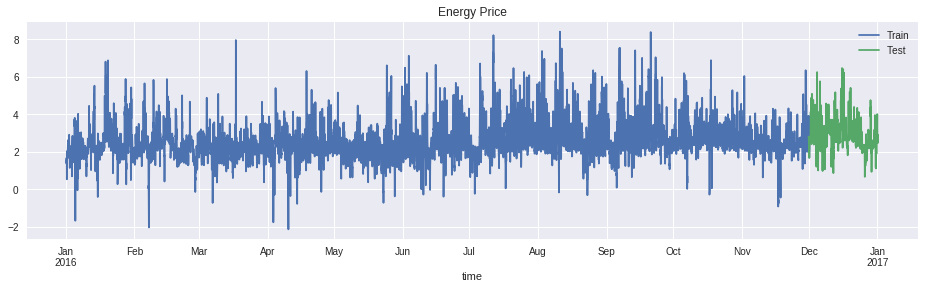

In [0]:
hour['price'][:'2016-12-01'].plot(figsize=(16,4),legend = True)
hour['price']['2016-12-01':].plot(figsize=(16,4),legend = True)
plt.legend(['Train','Test'])
plt.title('Energy Price')
plt.show()

# LSTM Model

In [0]:
training_set = hour['2016-11-01':'2016-12-30'].iloc[:,0:1].values
test_set = hour['2016-12-30':].iloc[:,0:1].values
#Scaling
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
test_set_scaled= sc.fit_transform(test_set)

In [0]:
X_train =[]
y_train = []
for i in range (24,training_set.shape[0]):
  X_train.append(training_set_scaled[i-24:i,0])
  y_train.append(training_set_scaled[i,0])
X_train , y_train = np.array(X_train),np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
y_train =y_train.reshape(y_train.shape[0],1)


In [0]:
#X test Defining
X_test = []
y_test = []
for i in range (24,test_set.shape[0]):
  X_test.append(test_set_scaled[i-24:i,0])
  y_test.append(test_set_scaled[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
y_test =y_test.reshape(y_test.shape[0],1)

In [0]:
model = Sequential()
layers = [1, 50,100, 1]


In [0]:
#model 1:
model.add(LSTM(layers[1],input_shape=(X_train.shape[1],1),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(layers[2],return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(layers[3]))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.fit(X_train, y_train,batch_size=8, nb_epoch=4, validation_split=0.05)

Instructions for updating:
Use tf.cast instead.
Train on 1345 samples, validate on 71 samples
Epoch 1/4
1345/1345 [==============================] - 7s 5ms/step - loss: 0.0155 - acc: 0.0015 - val_loss: 0.0055 - val_acc: 0.0000e+00
Epoch 2/4
1345/1345 [==============================] - 5s 4ms/step - loss: 0.0104 - acc: 0.0015 - val_loss: 0.0042 - val_acc: 0.0000e+00
Epoch 3/4
1345/1345 [==============================] - 5s 4ms/step - loss: 0.0089 - acc: 0.0015 - val_loss: 0.0036 - val_acc: 0.0000e+00
Epoch 4/4
1345/1345 [==============================] - 5s 4ms/step - loss: 0.0079 - acc: 0.0015 - val_loss: 0.0041 - val_acc: 0.0000e+00


In [0]:
prediction = model.predict(X_test)
score = model.evaluate(X_test,y_test,verbose =0)
print('Test Loss:', score[0])

Test Loss: 0.05168777331709862


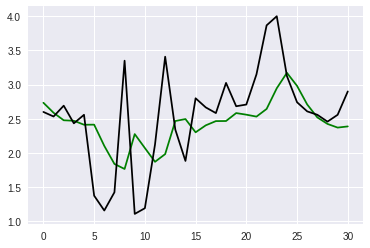

In [0]:
prediction = model.predict(X_test)
prediction = sc.inverse_transform(prediction)
y_test = sc.inverse_transform(y_test)
plt.plot(prediction, color='green',label='Predicted')
plt.plot(y_test, color='black',label='Real')
plt.show()

In [0]:
predicted = model.predict(X_train)
predicted = sc.inverse_transform(predicted)
y_train = sc.inverse_transform(y_train)

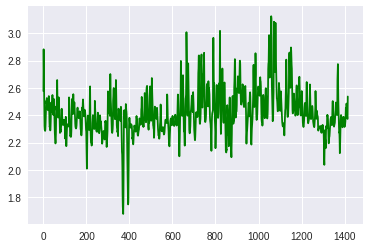

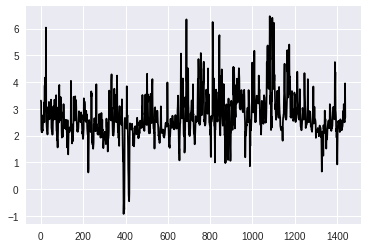

In [0]:
plt.plot(predicted, color='green',label='Predicted')
plt.show()
plt.plot(training_set, color='black',label='Real')
plt.show()

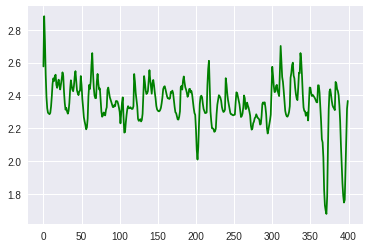

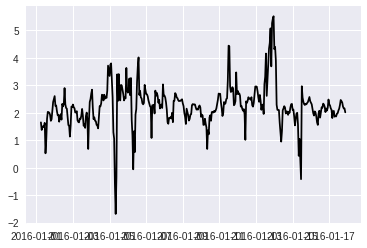

In [0]:
plt.plot(predicted[0:400], color='green',label='Predicted')
plt.show()
plt.plot(hour[0:400], color='black',label='Real')
plt.show()

#GRU

In [0]:
training_set = hour['2016-11-01':'2016-12-30'].iloc[:,0:1].values
test_set = hour['2016-12-30':].iloc[:,0:1].values
#Scaling
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
test_set_scaled= sc.fit_transform(test_set)

In [0]:
X_train =[]
y_train = []
for i in range (24,training_set.shape[0]):
  X_train.append(training_set_scaled[i-24:i,0])
  y_train.append(training_set_scaled[i,0])
X_train , y_train = np.array(X_train),np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
y_train =y_train.reshape(y_train.shape[0],1)
print(X_train.shape)


(1416, 24, 1)


In [0]:
#X test Defining
X_test = []
y_test = []
for i in range (24,test_set.shape[0]):
  X_test.append(test_set_scaled[i-24:i,0])
  y_test.append(test_set_scaled[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
y_test =y_test.reshape(y_test.shape[0],1)

In [0]:
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=4,batch_size=150)


Epoch 1/4
1416/1416 [==============================] - 3s 2ms/step - loss: 0.1038
Epoch 2/4
1416/1416 [==============================] - 1s 730us/step - loss: 0.0409
Epoch 3/4
1416/1416 [==============================] - 1s 729us/step - loss: 0.0235
Epoch 4/4
1416/1416 [==============================] - 1s 733us/step - loss: 0.0161


In [0]:
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)


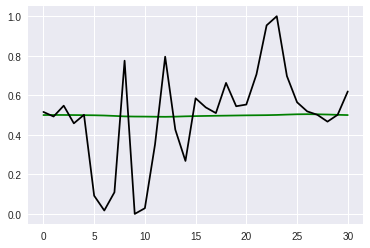

In [0]:
prediction = regressorGRU.predict(X_test)
#prediction = sc.inverse_transform(prediction)
#y_test = sc.inverse_transform(y_test)
plt.plot(prediction, color='green',label='Predicted')
plt.plot(y_test, color='black',label='Real')
plt.show()

# PCA


In [0]:
!pip install tsfresh

    100% |████████████████████████████████| 122kB 6.2MB/s 


In [0]:
X_train =[]
y_train = []
for i in range (24,training_set.shape[0]):
  X_train.append(training_set_scaled[i-24:i,0])
  y_train.append(training_set_scaled[i,0])

In [0]:
hourdata = pd.read_excel('/content/gdrive/My Drive/Colab Notebooks/1. DataAnalytics/~Code/Data/hourprice.xlsx',parse_dates=['time'])

In [0]:
arg1 = hourdata.set_index('time1')
y = pd.Series(arg1['price'])
X=hourdata.set_index('time1')

In [0]:
from tsfresh import extract_relevant_features,extract_features
ts = extract_features(hourdata[hourdata.shape[0]-training_set.shape[0]:hourdata.shape[0]], column_id='time1', column_sort='time')
# error ts = extract_relevant_features(hourdata[:10],y[:10],column_id='time1', column_sort='time')

Feature Extraction: 100%|██████████| 5/5 [01:08<00:00, 13.68s/it]


In [0]:
ts = ts.dropna(axis='columns')
ts =ts.loc[:, (ts != 0).any(axis=0)]
ts.to_excel('features.xlsx')
print(ts.shape)
list(ts)

(1440, 39)


['price__abs_energy',
 'price__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_10',
 'price__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_2',
 'price__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_20',
 'price__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_5',
 'price__energy_ratio_by_chunks__num_segments_10__segment_focus_0',
 'price__fft_coefficient__coeff_0__attr_"abs"',
 'price__fft_coefficient__coeff_0__attr_"angle"',
 'price__fft_coefficient__coeff_0__attr_"real"',
 'price__index_mass_quantile__q_0.1',
 'price__index_mass_quantile__q_0.2',
 'price__index_mass_quantile__q_0.3',
 'price__index_mass_quantile__q_0.4',
 'price__index_mass_quantile__q_0.6',
 'price__index_mass_quantile__q_0.7',
 'price__index_mass_quantile__q_0.8',
 'price__index_mass_quantile__q_0.9',
 'price__last_location_of_maximum',
 'price__last_location_of_minimum',
 'price__length',
 'price__longest_strike_above_mean',
 'price__longest_strike_below_mean',
 'price__maximum',
 'price__mean'

95% varince by 2nd component

Text(0, 0.5, 'Cumulative explained variance')

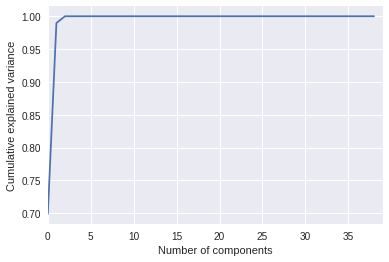

In [0]:
from sklearn.decomposition import PCA
pca = PCA().fit(ts)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,ts.shape[1],1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')


In [0]:
sklearn_pca = PCA(n_components=1)
Y_sklearn = sklearn_pca.fit_transform(df)
print(Y_sklearn)
Y_sklearn.shape


[[-0.54463182]
 [-0.54463182]
 [-0.74463182]
 ...
 [ 0.25536818]
 [ 0.35536818]
 [ 0.35536818]]


(102530, 1)

Thus Principal Component Analysis is used to remove the redundant features from the datasets without losing much information.These features are low dimensional in nature.The first component has the highest variance followed by second, third and so on.PCA works best on data set having 3 or higher dimensions. Because, with higher dimensions, it becomes increasingly difficult to make interpretations from the resultant cloud of data.

